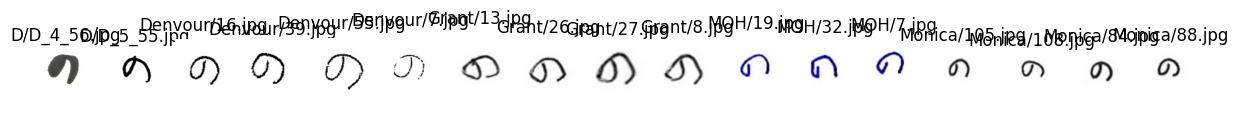

In [94]:
# C/C_1_1.jpg
# D/D_5_42.jpg
# D/D_4_8.jpg
# D/D_3_21.jpg
# D/D_5_5.jpg
# B/B_5_3.jpg
# B/B_3_40.jpg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
image_folder_path = '../../pilot data/data/'
common_character_group = ['は', 'か', 'へ', 'で', 'す', 'あ', 'お',
              'の', 'に', 'を', 'る', 'く', 'し', 'な', 'よ', 'ス', 'ル', 
              '日', '事', '人', '本', '大']
#,'上', '生','文','明','情', '国', '子', '用', '战', '手', '小','年' #No data
character = 'の'
#'か'，'の',
source_path = 'cluster/' + character +".csv"
df = pd.read_csv(source_path)
plt.figure(figsize=(15, 5))
for i in range(len(df)):
    image_path = os.path.join(image_folder_path, df.iloc[i]['Image_name'])
    image = plt.imread(image_path)
    
    # Create a subplot for each image
    ax = plt.subplot(1, len(df), i + 1)  # (1, number of images, index of current image)
    ax.imshow(image)
    ax.set_title(df.iloc[i]['Image_name'])
    ax.axis('off')  # Turn off axis labels and ticks

plt.show()

In [95]:
# Feature extraction part
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import cv2
import os
def label_image(img,cornerlist):
    """
    Label the correspond point in the image 
    Parameters:
    - img:  np.ndarray image read by plt
    - cornerlist : A list which store coordinate to highlight. 
    
    Returns: 
    - The labeled image. 
    """
    # iterate all the point in the coordinate list. 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for (x,y) in cornerlist:
        #x is row, y is column
        cv2.circle(img,(y,x),1, (0, 255, 0), -1)
    # return the image. 
    return img
def non_max_suppression(cornresult: np.ndarray, threshold: float = 0.01, K_size: int = 3) -> List[Tuple[int, int]]:
    """
    Utilize the result of Harris Corner Detection to fitrate those 
    local maxima (corners) and returned.

    Parameters:
    - cornresult: 2D array obtained from Harris_Corner()
    - threshold: Hyperparameter to determine a local maximum is considered a corner.
    - K_size: Size of the kernel used for non-maximum suppression.

    Returns:
    - List of tuples (row, column) indices of detected corners.
    """
    m, n = cornresult.shape
    supresult = []
    # Adding boundary to origin image so that can apply kernel on them
    k_half = K_size // 2
    padded_result = np.pad(cornresult, pad_width=k_half, mode='constant', constant_values=0)
    threshold = threshold * np.max(cornresult)
    # Iterate over the original image dimensions
    for r in range(m):
        for c in range(n):
            center_value = cornresult[r, c]
            if center_value == 0:
                continue
            # Extract 3*3 kernel
            local_patch = padded_result[r + k_half - k_half : r + k_half + k_half + 1,
                                        c + k_half - k_half : c + k_half + k_half + 1]
            # Ignore the corners of the padded_result, which correspond to the padding area
            if (r - k_half == 0 or r + k_half == m + k_half - 1 
                or c - k_half == 0 or c + k_half == n + k_half - 1):
                continue
            if center_value == np.max(local_patch) and center_value > threshold:
                supresult.append((r, c))
    
    return supresult

def pad_images_to_size(img, target_size=(80, 80)):
    
    if img is not None:
        h, w = img.shape[:2]
        if h > target_size[1] or w > target_size[0]: # adjust size in case image too big or too small
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        elif h < target_size[1] or w < target_size[0]:
            top = (target_size[1] - h) // 2
            bottom = target_size[1] - h - top
            left = (target_size[0] - w) // 2
            right = target_size[0] - w - left
            img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    return img
def load_local_image(file_path):
    """ load local images """
    if os.path.exists(file_path):
        image = cv2.imread(file_path)
        return image
    else:
        print(f"{file_path} doesnt exist")
        return None

import cv2
import matplotlib.pyplot as plt

def preprocess_image(image, margin=10, fixed_size=(200, 200)):
    if image is None:
        print("Nothing to preprocess")
        return None

    # convert it into grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # threshold
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    return binary

def extract_features(binary_image):
    features = {
        'white_pixels_ratio': np.sum(binary_image > 128) / binary_image.size
    }
    return features


#extract features with images set
def process_image_set(image_set, dir_path):
    """ deal with a set of image and feature extraction """
    features_list = []
    for file_name in image_set:
        file_path = os.path.join(dir_path, file_name)
        image = cv2.imread(file_path)
        if image is not None:
            preprocessed_image = preprocess_image(image)
            if preprocessed_image is not None:
                features = extract_features(preprocessed_image)
                if features is not None:
                    features_list.append(features)
            else:
                print(f"preprocessing {file_name} failed")
        else:
            print(f"loading {file_name} failed")
    return features_list
    
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import cv2
import os
# source_path = 'cluster/あ.csv'
df = pd.read_csv(source_path)
sum_m = 0
sum_n = 0
for i in range(len(df)):
    image_path = os.path.join(image_folder_path, df.iloc[i]['Image_name'])
    Img = cv2.imread(image_path)
    m,n = Img.shape[0],Img.shape[1]
    sum_m += m
    sum_n += n
sum_m = sum_m // len(df)
sum_n = sum_n // len(df)

feature_dots_len =[]
feature_dots = []
plt.figure(figsize=(15, 5))
for i in range(len(df)):
    image_path = os.path.join(image_folder_path, df.iloc[i]['Image_name'])
    Img = cv2.imread(image_path)
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
    Img = pad_images_to_size(Img,(round(sum_m),round(0.7*sum_n)))
    if Img.ndim == 3:
        gray_Img = cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY)
    else:
        gray_Img = Img  # If Img is already in grayscale

    #in-build function
    in_build_harris  = cv2.cornerHarris(gray_Img, 2, 3, 0.04)
    in_build_corner = non_max_suppression(in_build_harris)
    feature_dots.append(in_build_corner)
    feature_dots_len.append(len(in_build_corner))
    # convert image back to rgb form to display
    rgb_Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)

    img_with_corners = label_image(rgb_Img,in_build_corner)
#     plt.figure(figsize=(15, 5))

#     ax = plt.subplot(1,len(df),  i + 1)  # (number of rows, number of cols, index)
#     ax.imshow(img_with_corners)
#     ax.set_title('Harris Corner: ' + df.iloc[i]['Image_name'])
#     ax.axis('off')  # Hide axes

# plt.tight_layout()  # Adjust layout to fit all elements
# plt.show()
#extract features from image
feature_list = []
image_folder_path = '../../pilot data/data/'

# source_path = 'cluster/あ.csv'
df = pd.read_csv(source_path)
for i in range(len(df)):
    image_path = os.path.join(image_folder_path, df.iloc[i]['Image_name'])
    image = load_local_image(image_path)
    if image is not None:
        preprocessed_image = preprocess_image(image)
        if preprocessed_image is not None:
            features = extract_features(preprocessed_image)
            if features is not None:
                feature_list.append((df.iloc[i]['Image_name'],features))
def compute_corner_density(corners, image_width, image_height):
    num_corners = len(corners)
    area = image_width * image_height
    density = num_corners / area
    return density

def compute_corner_stats(corners):
    x_coords = [coord[0] for coord in corners]
    y_coords = [coord[1] for coord in corners]
    
    stats = {
        'mean_x': np.mean(x_coords),
        'mean_y': np.mean(y_coords),
        'var_x': np.var(x_coords),
        'var_y': np.var(y_coords)
    }
    return stats

def compute_bounding_box_size(corners):
    x_coords = [coord[0] for coord in corners]
    y_coords = [coord[1] for coord in corners]
    
    min_x = min(x_coords)
    max_x = max(x_coords)
    min_y = min(y_coords)
    max_y = max(y_coords)
    
    width = max_x - min_x
    height = max_y - min_y
    return width, height

for index, (img,feature) in enumerate(feature_list):
    corners = feature_dots[index]
    dots_len = feature_dots_len[index]
    density = compute_corner_density(corners, sum_m,round(sum_n*0.7))
    stats = compute_corner_stats(corners)
    s_width,s_height = compute_bounding_box_size(corners)
    feature['corner_num'] = dots_len
    feature['corner_density'] = density
    for k,v in stats.items():
        feature[k] = v
    feature['smallest_width'] = s_width
    feature['smallest_height'] = s_height


print(str(feature_list[0][:]))


('D/D_4_56.jpg', {'white_pixels_ratio': 0.206567242281528, 'corner_num': 5, 'corner_density': 0.00038553473667977484, 'mean_x': 51.6, 'mean_y': 58.4, 'var_x': 581.8399999999999, 'var_y': 390.64, 'smallest_width': 64, 'smallest_height': 53})


<Figure size 1500x500 with 0 Axes>

In [97]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import os
from sklearn.decomposition import PCA
data = []
for file_name, features in feature_list:
    entry = [
        features['white_pixels_ratio'],
        features['corner_num'],
        features['corner_density'],
        features['mean_x'],
        features['mean_y'],
        features['var_x'],
        features['var_y'],
        features['smallest_width'],
        features['smallest_height']
    ]
    data.append(entry)

data = np.array(data)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)



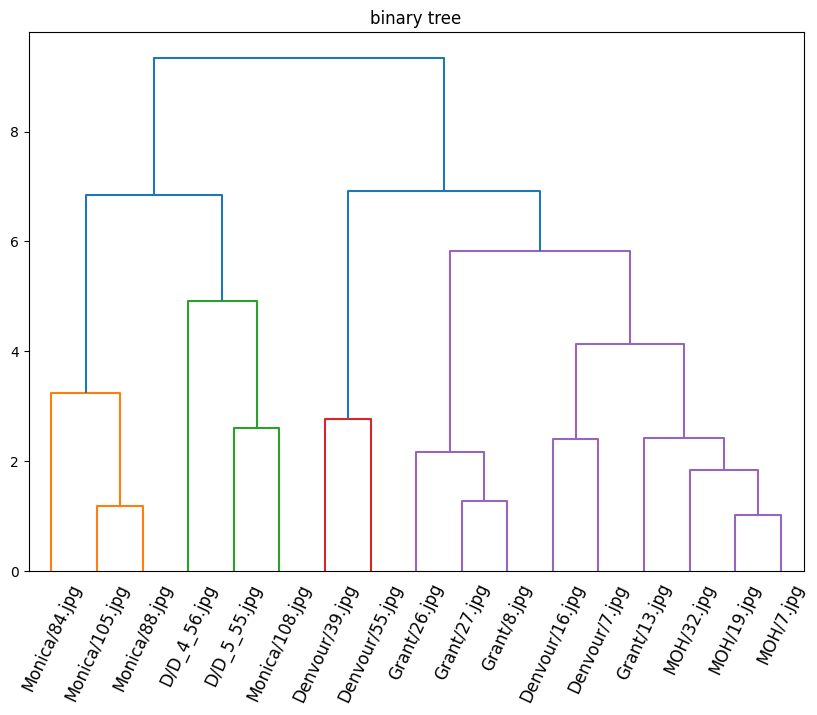

In [98]:
import numpy as np #CoHiClust
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

Z = linkage(data_scaled, method='ward')
plt.figure(figsize=(10, 7))
image_names = [item[0] for item in feature_list]
dendrogram(Z,labels = image_names)
plt.xticks(rotation=65) 
plt.title('binary tree')
plt.show()
max_dist = 0.2
max_depth = 4 """see below docstring"""
cluster_labels = fcluster(Z, max_depth, criterion='distance')
coHi_dict = defaultdict(list)
for index, label in enumerate(cluster_labels):
    coHi_dict[label].append(index)

In [ ]:
"""
About max_depth:
Undoubtly, it is most important parameter in cluster algorithm as it directly vary cluster result either stricter or tighter
However, when taking different number of input, this parameter need adjustment. 

It should somehow looks like:
def calculate_max_distance(data):
    variance = np.var(data)
    return variance * 0.1  # need experiment to test

need test with different number of input. 
Or simply enable user to ajust a bar which indicates max_depth for making result stricter or tighter
"""

Cluster 3: ['D/D_4_56.jpg']


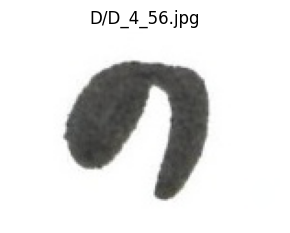

Cluster 2: ['D/D_5_55.jpg', 'Monica/108.jpg']


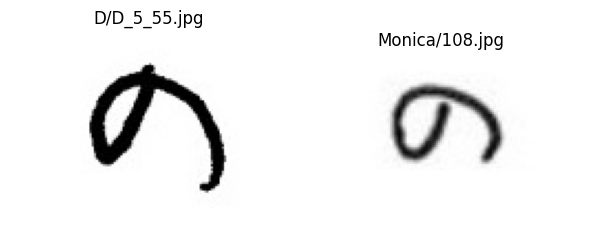

Cluster 6: ['Denvour/16.jpg', 'Denvour/7.jpg']


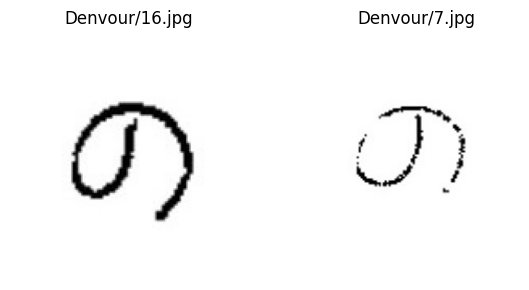

Cluster 4: ['Denvour/39.jpg', 'Denvour/55.jpg']


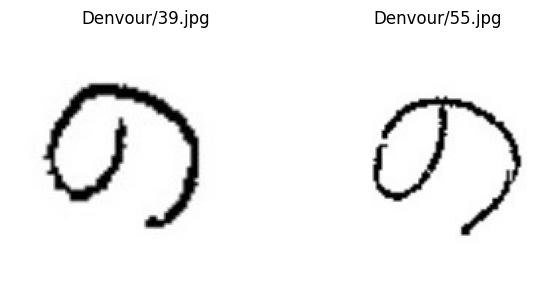

Cluster 7: ['Grant/13.jpg', 'MOH/19.jpg', 'MOH/32.jpg', 'MOH/7.jpg']


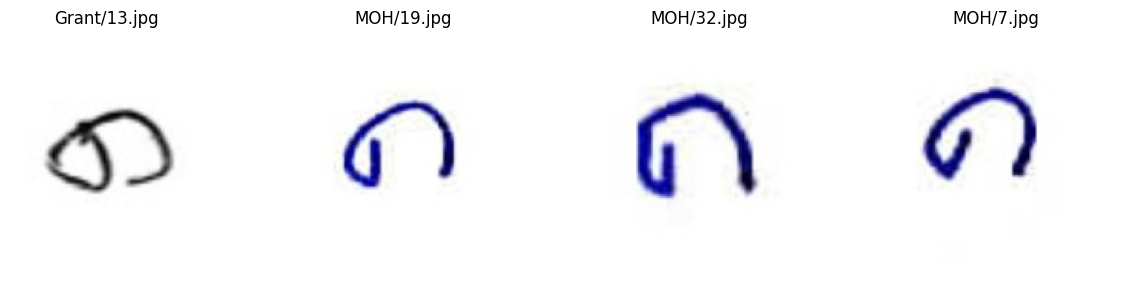

Cluster 5: ['Grant/26.jpg', 'Grant/27.jpg', 'Grant/8.jpg']


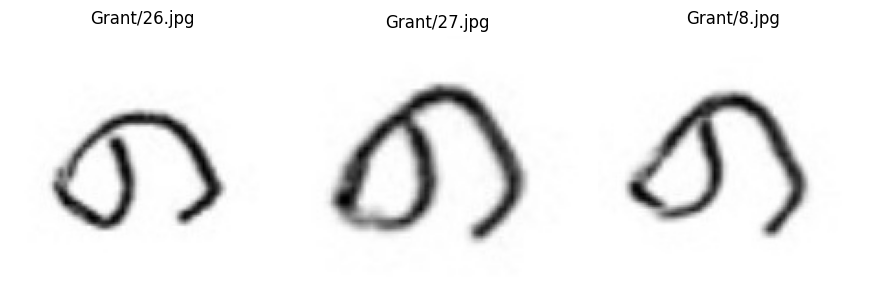

Cluster 1: ['Monica/105.jpg', 'Monica/84.jpg', 'Monica/88.jpg']


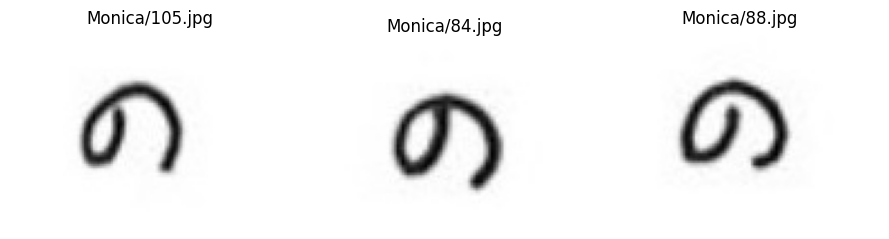

After classifying with hierarchical clustering at max depth 4, the following images are likely to have the same author:
'D/D_5_55.jpg', and 'Monica/108.jpg' have the same author.
'Denvour/16.jpg', and 'Denvour/7.jpg' have the same author.
'Denvour/39.jpg', and 'Denvour/55.jpg' have the same author.
'Grant/13.jpg', 'MOH/19.jpg', 'MOH/32.jpg', and 'MOH/7.jpg' have the same author.
'Grant/26.jpg', 'Grant/27.jpg', and 'Grant/8.jpg' have the same author.
'Monica/105.jpg', 'Monica/84.jpg', and 'Monica/88.jpg' have the same author.


In [99]:
cluster_dict = defaultdict(list)
for cluster_label, indices in coHi_dict.items():
    for index in indices:
        image_name = feature_list[index][0]
        cluster_dict[cluster_label].append(image_name)

# Display the clustering results
cluster_images = []
for cluster, images in cluster_dict.items():
    if cluster != -1: 
        print(f"Cluster {cluster}: {images}")
        imageset = []
        plt.figure(figsize=(3 * len(images), 3))  
        for index, img_name in enumerate(images):
            
            image_path = os.path.join(image_folder_path, img_name) 
            image = plt.imread(image_path) 
            ax = plt.subplot(1, len(images), index + 1)  
            ax.imshow(image)
            ax.set_title(img_name)
            ax.axis('off')
            imageset.append(img_name)
        plt.tight_layout()
        plt.show()
        cluster_images.append(imageset)

# Summarize the clustering results
print(f"After classifying with hierarchical clustering at max depth {max_depth}, the following images are likely to have the same author:")
if len(cluster_images) >= 1:
    for images in cluster_images:
        if len(images) > 1:
            images_formatted = "', '".join(images[:-1])
            summary_statement = f"'{images_formatted}', and '{images[-1]}' have the same author."
            print(summary_statement)

In [110]:
from sklearn.decomposition import PCA # DBSCAN
from sklearn.cluster import DBSCAN

hyper_data = pd.read_excel("DBSCAN.xlsx")

data_row = hyper_data[hyper_data['character'] == character]
ep = int(data_row['eps'].iloc[0])
min_sample = int(data_row['min_sample'].iloc[0])
PCA_n = int(data_row['PCA'].iloc[0])
pca = PCA(n_components= PCA_n) #higher, stricter

data_reduced = pca.fit_transform(data_scaled)
dbscan = DBSCAN(eps = ep, min_samples=min_sample) #eps lower, stricter
dbscan.fit(data_reduced)

clusters = dbscan.labels_

print("Cluster assignments after PCA:", clusters)

Cluster assignments after PCA: [-1 -1 -1 -1 -1 -1 -1 -1  0  0  1 -1  1  2 -1 -1  2]


Cluster 0: ['Grant/27.jpg', 'Grant/8.jpg']


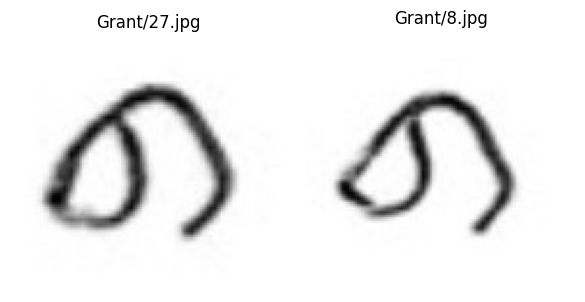

Cluster 1: ['MOH/19.jpg', 'MOH/7.jpg']


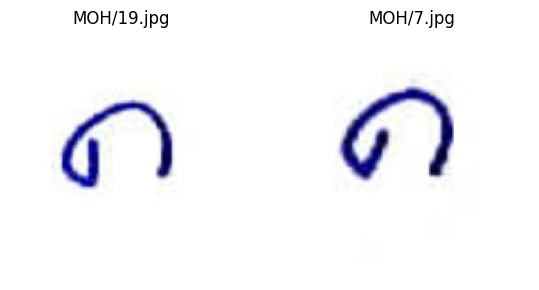

Cluster 2: ['Monica/105.jpg', 'Monica/88.jpg']


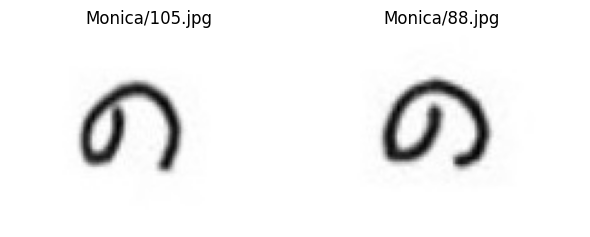

After classifying with DBSCAN, the following images are likely to have the same author:

'Grant/27.jpg', and 'Grant/8.jpg' have the same author.

'MOH/19.jpg', and 'MOH/7.jpg' have the same author.

'Monica/105.jpg', and 'Monica/88.jpg' have the same author.


In [111]:
from collections import defaultdict

cluster_dict = defaultdict(list)

# Populate the cluster dictionary based on DBSCAN labels
for index, cluster_label in enumerate(dbscan.labels_):
    image_name = feature_list[index][0]
    cluster_dict[cluster_label].append(image_name)

# Display the clustering results
cluster_images = []
for cluster, images in cluster_dict.items():
    if cluster != -1:  # -1 represents noise in DBSCAN, you might want to ignore it
        print(f"Cluster {cluster}: {images}")
        imageset = []
        plt.figure(figsize=(3 * len(images), 3))
        for index, img_name in enumerate(images):
            
            image_path = os.path.join(image_folder_path, img_name)
            image = plt.imread(image_path)
            ax = plt.subplot(1, len(images), index + 1)
            ax.imshow(image)
            ax.set_title(img_name)
            ax.axis('off')
            imageset.append(img_name)
        plt.tight_layout()
        plt.show()
        cluster_images.append(imageset)

# Summarize the clustering results
print(f"After classifying with DBSCAN, the following images are likely to have the same author:")
if len(cluster_images) >= 1:
    for images in cluster_images:
        if len(images) > 1:
            images_formatted = "', '".join(images[:-1])
            print()
            summary_statement = f"'{images_formatted}', and '{images[-1]}' have the same author."
            print(summary_statement)